<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/NU/Lab4_Alpha_range.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4 Nuclear Experiment. Alpha range

Evgeny Kolonsky

v.0.1.3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Set #1

Po-210 dated 10.2024

Constants and parameters

In [5]:
di = 10 # distance between shelves, mm
d0 = 12.3 # distance between top shelf and GM counter window, mm
r = 31.6 / 2 # GM window radius, mm
shelf_thickness = 2.0 # sample shelf thickness, mm
tablet_thikness = 3.4 # Po-210 sample is slighly over the shelf, mm
tablet_inner_radius = 6.1 /2 # mm
sample_height = 1.0 # mm estimated. Polonium source is small amount on the bottom of inner hole of the tablet
rho_mica = 2.0 # mg/cm2, GM window areal density
rho_air  = 1.3 # mg/cm3, air density at room temperature
I_background = 0.29 # counts /s
E_alpha = 5.3 #MeV, decay energy reference for Po-210
# Expected range, mg/cm2
R1 = 0.4 * E_alpha**1.5
# Expected range, mm
R2 = 3.2 * E_alpha**1.5
# spacers
spacers_height = np.array([0, 1.06, 1.98, 2.92, 4.16, 5.02, 6.10, 7.02, 8.10, 9.02])  # spacers height +- 0.02 mm

Solid angle
$$
\Omega = 2 \pi \left( 1 - \frac{1}{\sqrt{1+(r/h)^2}}\right)
\tag{13}
$$

Range as length
$$
R = 0.32 \, {E_\alpha} ^{3/2}
\tag{5}
$$
where $E_{\alpha}$ measured in `MeV`, range $R$ in `cm`.

Range as areal density
$$
R = 0.4 \, {E_\alpha} ^{3/2}
\tag{5}
$$
where $E_{\alpha}$ measured in `MeV`, range $R$ in `mg/cm2`.

Measurements

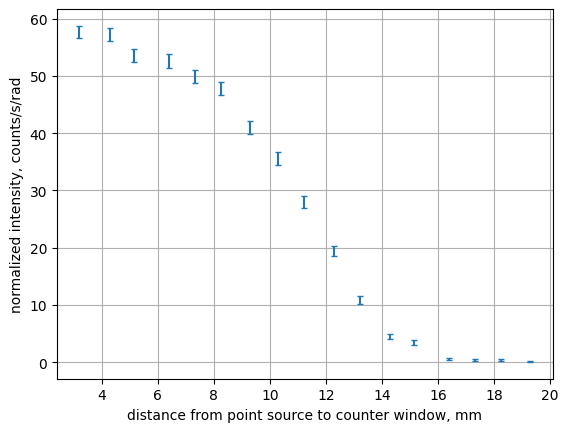

In [7]:
data = '''
# shelf#, spacers/mm, counts, time/s
# measured 17.11.2024
1 0 7819 60
2 0 80 143
2 2.5 80 110
2 5.0 289 64
2 7.5 3625 84
2 8.0 3681 60
2 8.2 4953 61
2 9.0 1718 21
2 9.0 3559 45
2 9.0 3138 35
1 0.7 9366 61
1 3.0 9202 43
1 6.0 10721 37
'''

data = '''
# shelf#, spacer#, time/s, counts,
# measured 21.11.2024 with spacers
2 0 10 3
2 1 10 6
2 2 10 7
2 3 10 10
2 4 10 66
2 5 10 93
2 6 10 247
2 7 10 472
2 8 10 743
2 9 10 1017
1 0 10 1268
1 1 10 1615
1 2 10 1817
1 3 10 2068
1 4 10 2322
1 5 10 2657
1 6 10 2903
'''

n, spacer, time, counts = np.loadtxt(data.splitlines(), unpack=True, dtype=int)
# distance
h = d0 + (n - 1) * di - shelf_thickness - sample_height - spacers_height[spacer]
# solid angle
omega = 2 * np.pi * (1 - 1 / np.sqrt(1 + (r / h)**2))
# intensity
delta = 1/np.sqrt(counts) # relative error
I = counts / time
I_norm = I / omega
I_err = delta * I_norm


plt.errorbar(h, I_norm, yerr=I_err, linestyle='', capsize=2)
plt.xlabel('distance from point source to counter window, mm')
plt.ylabel('normalized intensity, counts/s/rad')
plt.grid()

# GM Specification data

Effective range is limited by GM mica window.

According to counter [documentation](https://www.lip.pt/~patricia/FisicaDaRadiacao/Geiger-Mueller-Detectors-Canberra-sheet.pdf) (fig. below) we expect to have range 15 mm for energy over 2.6 MeV.


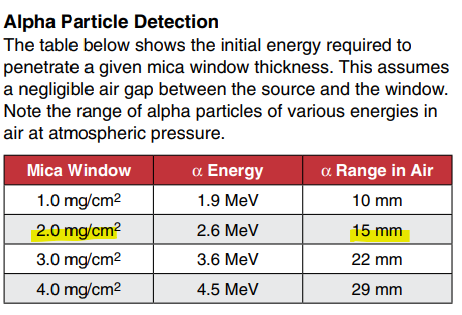

# From linear distance to areal density

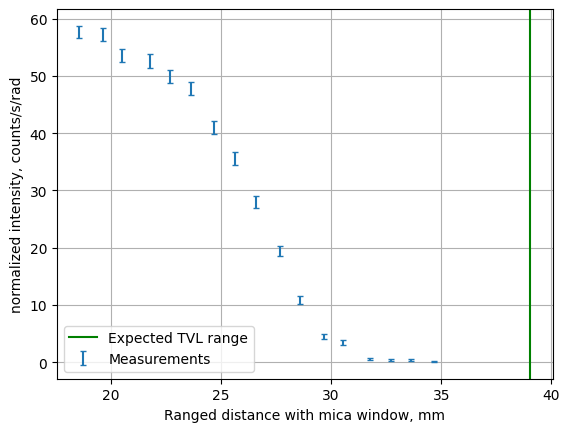

In [17]:
w = h + rho_mica/rho_air * 10 # effective distance in
plt.errorbar(w, I_norm, yerr=I_err, linestyle='', capsize=2, label='Measurements')
plt.axvline(R2,  color='green', label='Expected TVL range')
plt.xlabel('Ranged distance with mica window, mm')
plt.ylabel('normalized intensity, counts/s/rad')
plt.legend()
plt.grid()

**Conclusion**

Measured range  28 mm correspondes rather good to range shown in GM counter specification for mica window areal density 2 mg/cm2.

Expected range is 38 mm. Difference 10 mm could be explained by additional distance that particle travels inside GM counter before avalanche happens.

In [12]:
omega / 2 / np.pi

array([0.22622136, 0.24414687, 0.26121907, 0.28026549, 0.30813434,
       0.32948021, 0.3588606 , 0.3863362 , 0.42169617, 0.45463876,
       0.49274153, 0.53758743, 0.57963123, 0.62557576, 0.69064176,
       0.7385371 , 0.80149861])

In [13]:
r/h

array([0.81865285, 0.86622807, 0.91224018, 0.96459096, 1.04359313,
       1.10644258, 1.1969697 , 1.28664495, 1.41071429, 1.53696498,
       1.69892473, 1.91747573, 2.15846995, 2.47648903, 3.07392996,
       3.69158879, 4.9375    ])

In [14]:
tablet_inner_radius / (tablet_thikness - sample_height)

1.2708333333333333

In [16]:
h[7], omega[7] / 2 / np.pi

(12.280000000000001, 0.3863361956723837)